In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time
import winsound

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

In [2]:
print(tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

[]


In [3]:
# tf.random.set_seed(42)

base_path = 'dataset/'
train_dir = os.path.join(base_path, 'train')

train_csv = os.path.join(base_path, 'train', '_annotations.csv')
valid_csv = os.path.join(base_path, 'valid', '_annotations.csv')
test_csv = os.path.join(base_path, 'test', '_annotations.csv')
                        
# Function to load and preprocess images
def load_and_preprocess_image(filename, label, bbox):
    try:
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [360, 360])  # VGG16 input size
        img = tf.cast(img, tf.float32)  / 255.0
        #img = tf.keras.applications.vgg16.preprocess_input(img)
        return img, label, bbox
    except tf.errors.NotFoundError:
        print(f"File not found: {filename}")
        return None, None, None


In [4]:
    
# Function to load data from CSV and create a dataset
def create_dataset(csv_file,base_dir, is_training=True):
    df = pd.read_csv(csv_file)
    unique_labels = df['class'].unique()
    print(unique_labels)
    # Encode class labels
    le = LabelEncoder()
    df['class'] = le.fit_transform(df['class'])

    filenames = df['filename'].apply(lambda x: os.path.join(base_dir, x)).values
    labels = df['class'].values


    bboxes = df[['xmin', 'ymin', 'xmax', 'ymax']].values
    
    #print(f"filename:{filenames}")
    print(f"Base Dir: {base_dir}")
    print(f"Labels shape: {labels.shape}")
    print(f"Bounding boxes shape: {bboxes.shape}")
    print(len(le.classes_))
    
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels, bboxes))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.filter(lambda x, y, z: x is not None)  # Filter out None values
 
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(32)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset, le

# Create datasets one by one for train , valid , test
train_dataset, label_encoder = create_dataset(train_csv, os.path.join(base_path, 'train'))
valid_dataset, _ = create_dataset(valid_csv, os.path.join(base_path, 'valid'), is_training=False)
test_dataset, _ = create_dataset(test_csv, os.path.join(base_path, 'test'), is_training=False)

['Rifle' 'HandGun' 'ShotGun' 'SMG' 'Knife']
Base Dir: dataset/train
Labels shape: (5554,)
Bounding boxes shape: (5554, 4)
5
['HandGun' 'Rifle' 'ShotGun' 'SMG' 'Knife']
Base Dir: dataset/valid
Labels shape: (824,)
Bounding boxes shape: (824, 4)
5
['SMG' 'ShotGun' 'HandGun' 'Rifle' 'Knife']
Base Dir: dataset/test
Labels shape: (468,)
Bounding boxes shape: (468, 4)
5


In [5]:
# Create a custom VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(360, 360, 3))
base_model.trainable = False

inputs = Input(shape=(360, 360, 3))

x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

lent=5
print(lent)
class_output = Dense(5, activation='softmax', name='class_output')(x)
bbox_output = Dense(4, name='bbox_output')(x)
model = Model(inputs=inputs, outputs=[class_output, bbox_output])

for batch in train_dataset.take(1):
    images, labels, bboxes = batch
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    print(f"Batch bounding boxes shape: {bboxes.shape}")


model.summary()


5
Batch images shape: (32, 360, 360, 3)
Batch labels shape: (32,)
Batch bounding boxes shape: (32, 4)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 360, 360,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 11, 11,    │ 14,714,688 │ input_layer_1[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 5)         │        645 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │        516 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 14,781,513 (56.39 MB)

 Trainable params: 66,825 (261.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [6]:
for batch in train_dataset.take(1):
    print(f"Batch shapes: {[x.shape for x in batch]}")

# Check data shapes
for batch in train_dataset.take(2):
    images, labels, bboxes = batch
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    print(f"Batch bounding boxes shape: {bboxes.shape}")

Batch shapes: [TensorShape([32, 360, 360, 3]), TensorShape([32]), TensorShape([32, 4])]
Batch images shape: (32, 360, 360, 3)
Batch labels shape: (32,)
Batch bounding boxes shape: (32, 4)
Batch images shape: (32, 360, 360, 3)
Batch labels shape: (32,)
Batch bounding boxes shape: (32, 4)


In [7]:
for batch1 in valid_dataset.take(1):
    print(f"Batch shapes: {[x.shape for x in batch]}")

# Check data shapes
for batch1 in valid_dataset.take(2):
    images, labels, bboxes = batch
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    print(f"Batch bounding boxes shape: {bboxes.shape}")

Batch shapes: [TensorShape([32, 360, 360, 3]), TensorShape([32]), TensorShape([32, 4])]
Batch images shape: (32, 360, 360, 3)
Batch labels shape: (32,)
Batch bounding boxes shape: (32, 4)
Batch images shape: (32, 360, 360, 3)
Batch labels shape: (32,)
Batch bounding boxes shape: (32, 4)


In [8]:
model.compile(optimizer='adam', 
              loss={'class_output': 'sparse_categorical_crossentropy', 'bbox_output': 'mse'},
              metrics={'class_output': 'accuracy','bbox_output': 'mae'}
              )


In [9]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

checkpoint_dir = './checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

In [10]:

def train_step(images, labels, bboxes):
    with tf.GradientTape() as tape:
        class_predictions, bbox_predictions = model(images, training=True)
        class_loss = tf.keras.losses.sparse_categorical_crossentropy(labels, class_predictions)
        bbox_loss = tf.keras.losses.MeanSquaredError()(bboxes, bbox_predictions)  # Corrected
        total_loss = tf.reduce_mean(tf.cast(class_loss, tf.float32)) + tf.reduce_mean(tf.cast(bbox_loss, tf.float32))
        
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss

def validation_step(images, labels, bboxes):
    predictions = model(images, training=False)
    class_predictions, bbox_predictions = predictions
    class_loss = tf.keras.losses.sparse_categorical_crossentropy(labels, class_predictions)
    bbox_loss = tf.keras.losses.MeanSquaredError()(bboxes, bbox_predictions)
    total_loss = tf.reduce_mean(class_loss) + tf.reduce_mean(bbox_loss)
    return total_loss

In [11]:
# Load the latest checkpoint (if any)
if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print(f"Restored from {checkpoint_manager.latest_checkpoint}")
else:
    print("Starting from scratch.")


Starting from scratch.


In [12]:
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

num_epochs = 10  # Set your number of epochs
for epoch in range(num_epochs):
    start_time = time.time()
    print(f'Epoch {epoch + 1}/{num_epochs}')
    epoch_loss = 0
    train_accuracy.reset_state()

    # Training
    for batch in train_dataset:
        images, labels, bboxes = batch
        batch_loss = train_step(images, labels, bboxes)
        epoch_loss += batch_loss
        train_accuracy.update_state(labels, model(images, training=True)[0])

    # Validation
    val_loss = 0
    val_accuracy.reset_state()
    for batch1 in valid_dataset:
        images, labels, bboxes = batch1
        batch_val_loss = validation_step(images, labels, bboxes)
        val_loss += batch_val_loss
        val_accuracy.update_state(labels, model(images, training=False)[0])

    elapsed_time = time.time() - start_time

    #print(f'Epoch {epoch + 1} - Loss: {epoch_loss.numpy()} - Validation Loss: {val_loss.numpy()}')
    print(f'Epoch {epoch + 1} - Loss: {epoch_loss.numpy():.4f} - Validation Loss: {val_loss.numpy():.4f}')
    print(f'Train Accuracy: {train_accuracy.result().numpy():.4f} - Validation Accuracy: {val_accuracy.result().numpy():.4f}')
    print(f'Time for epoch {epoch + 1}: {elapsed_time:.2f} seconds\n')

    # Save the model's weights after each epoch
    checkpoint_manager.save()
    print(f"Checkpoint saved for epoch {epoch + 1}\n")
    
    # After the process finishes+
    duration = 1000  # milliseconds
    freq = 440  # Hz
    winsound.Beep(freq, duration)

Epoch 1/10
Epoch 1 - Loss: 5164496.5000 - Validation Loss: 281473.7500
Train Accuracy: 0.2803 - Validation Accuracy: 0.3714
Time for epoch 1: 13640.68 seconds

Checkpoint saved for epoch 1

Epoch 2/10
Epoch 2 - Loss: 1403893.5000 - Validation Loss: 192568.2344
Train Accuracy: 0.2946 - Validation Accuracy: 0.2961
Time for epoch 2: 15329.94 seconds

Checkpoint saved for epoch 2

Epoch 3/10
Epoch 3 - Loss: 1309548.8750 - Validation Loss: 191322.2812
Train Accuracy: 0.3335 - Validation Accuracy: 0.3714
Time for epoch 3: 14565.33 seconds

Checkpoint saved for epoch 3

Epoch 4/10
Epoch 4 - Loss: 1269137.6250 - Validation Loss: 188935.3594
Train Accuracy: 0.3441 - Validation Accuracy: 0.3641
Time for epoch 4: 14651.10 seconds

Checkpoint saved for epoch 4

Epoch 5/10
Epoch 5 - Loss: 1268338.8750 - Validation Loss: 185771.0156
Train Accuracy: 0.3556 - Validation Accuracy: 0.3883
Time for epoch 5: 13328.20 seconds

Checkpoint saved for epoch 5

Epoch 6/10
Epoch 6 - Loss: 1248839.8750 - Validati

In [13]:
# Evaluate on test dataset
test_loss = 0
for batch in test_dataset:
    images, labels, bboxes = batch
    batch_test_loss = validation_step(images, labels, bboxes)  # You can reuse validation_step here
    test_loss += batch_test_loss

print(f'Test Loss: {test_loss.numpy()}')

Test Loss: 97737.9375


In [14]:
model.save('model/model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


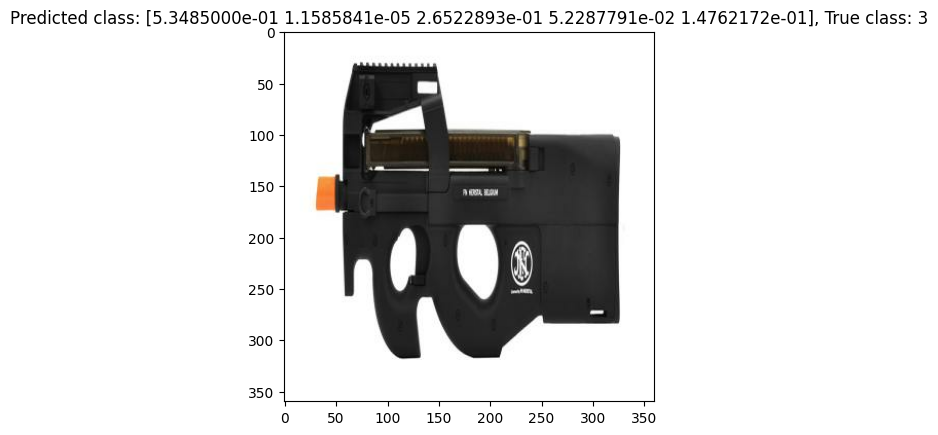

In [15]:
for batch in test_dataset.take(1):  # Take one batch of images
    images, labels, bboxes = batch
    pred_class, pred_bboxes = model.predict(images)
    
    # Display one example
    plt.imshow(images[0])
    plt.title(f'Predicted class: {pred_class[0]}, True class: {labels[0]}')
    plt.show()

In [16]:
# For classification accuracy
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
for batch in test_dataset:
    images, labels, bboxes = batch
    pred_class, pred_bboxes = model(images, training=False)
    accuracy.update_state(labels, pred_class)

print(f'Test Accuracy: {accuracy.result().numpy()}')


Test Accuracy: 0.3055555522441864


In [17]:
# model.fit(
#             train_dataset,
#             validation_data=valid_dataset,
#             epochs=10,  # Adjust as needed
#             verbose=1
#         )